In [ ]:
!pip install pysal
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from libpysal.weights.util import min_threshold_distance
from pysal.lib import cg as geometry
from pysal.viz import splot
from pysal.explore import esda
from pysal.lib import weights
from splot import esda as esdaplot
from shapely import wkt
from shapely.geometry import Point

In [ ]:
# loading orginal dataset
housing_df = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/cali_housing.csv')

In [ ]:
# Summary statistics
housing_df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housingMedianAge,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
totalRooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
totalBedrooms,20640.0,537.898014,421.247906,1.0000,295.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
medianIncome,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
medianHouseValue,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [ ]:
# Data structure
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   longitude         20640 non-null  float64
 1   latitude          20640 non-null  float64
 2   housingMedianAge  20640 non-null  float64
 3   totalRooms        20640 non-null  float64
 4   totalBedrooms     20640 non-null  float64
 5   population        20640 non-null  float64
 6   households        20640 non-null  float64
 7   medianIncome      20640 non-null  float64
 8   medianHouseValue  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
# Dropping lat and long from rest of EDA
vars_df = housing_df.drop(columns = ['latitude', 'longitude'])
vars_df.columns

Index(['housingMedianAge', 'totalRooms', 'totalBedrooms', 'population',
       'households', 'medianIncome', 'medianHouseValue'],
      dtype='object')

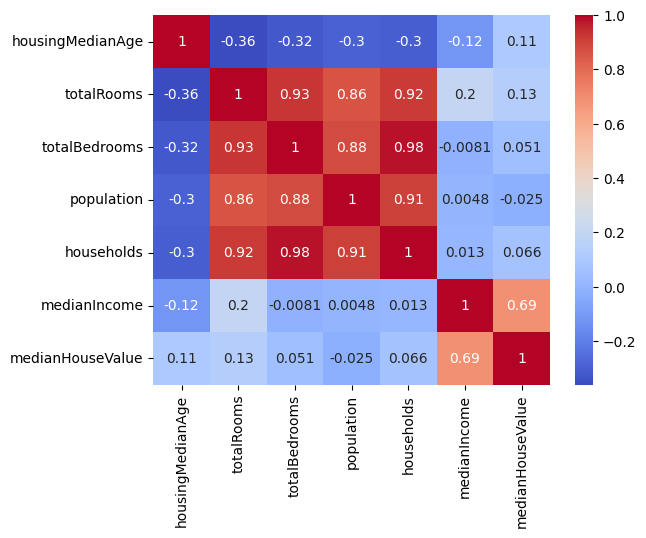

In [ ]:
# Correlation matrix of original predictors
corr_matrix = vars_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# feature engineering
housing_df['averageRooms'] = housing_df['totalRooms']/housing_df['households']
housing_df['averageBedrooms'] = housing_df['totalBedrooms']/housing_df['households']
housing_df['popPerHouse'] = housing_df['population']/housing_df['households']
housing_df = housing_df.drop(columns=['totalRooms', 'totalBedrooms', 'households'])

In [ ]:
# Creating new vars DF based on new features
vars_df2 = housing_df.drop(columns = ['latitude', 'longitude'])
vars_df2.columns

Index(['housingMedianAge', 'population', 'medianIncome', 'medianHouseValue',
       'averageRooms', 'averageBedrooms', 'popPerHouse'],
      dtype='object')

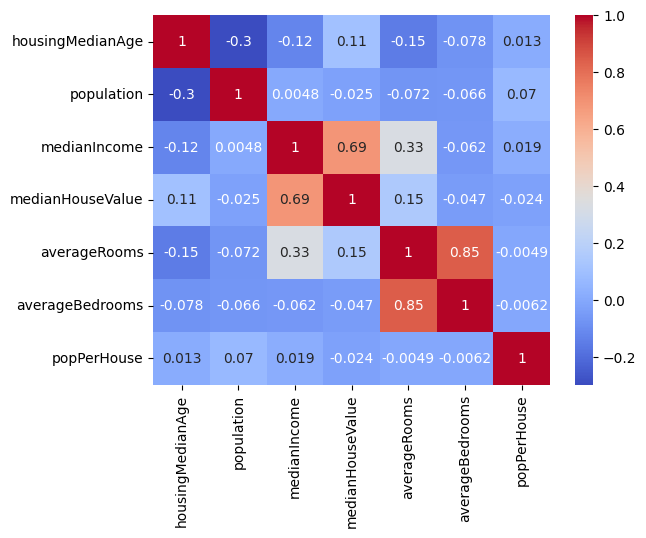

In [ ]:
# Correlation matrix after feature engineering
corr_matrix = vars_df2.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

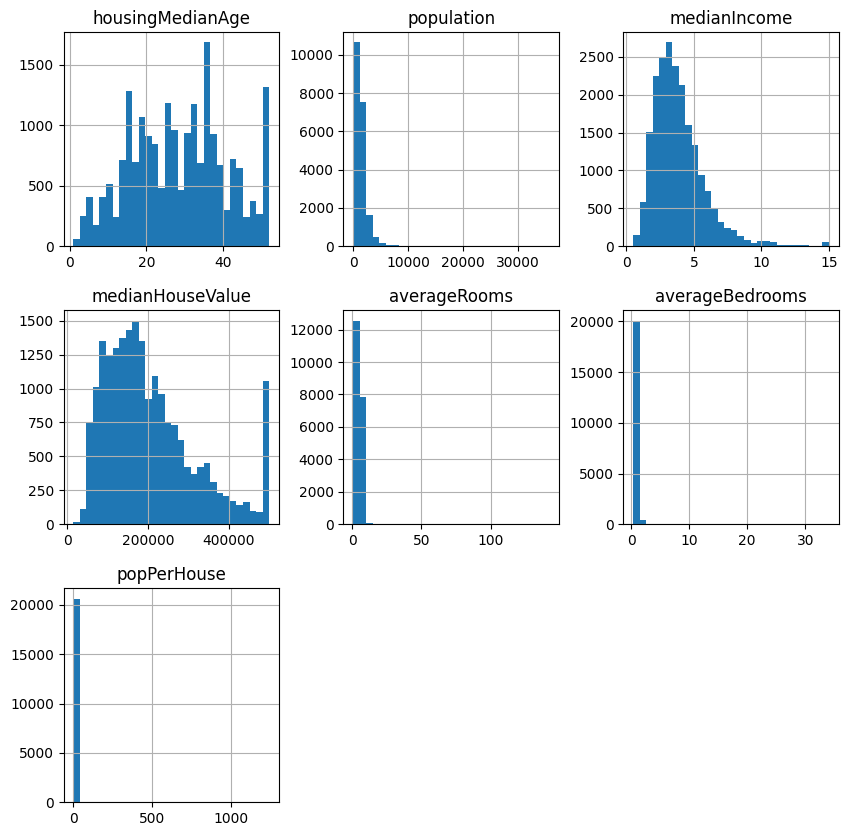

In [ ]:
# Histograms after feature engineering
vars_df2.hist(bins=30, figsize=(10, 10))
plt.show()

In [ ]:
# Log transforming skewed variables variables
log_vars = ['medianHouseValue','medianIncome','averageRooms', 'averageBedrooms', 'popPerHouse', 'population']
for i in range(len(log_vars)):
    var = log_vars[i]
    housing_df[f'log_{var}'] = np.log(housing_df[var])
housing_df = housing_df.drop(columns=log_vars)

In [ ]:
# Creating new vars DF based on log-transformed vars
vars_df3 = housing_df.drop(columns = ['latitude', 'longitude'])
vars_df3.columns

Index(['housingMedianAge', 'log_medianHouseValue', 'log_medianIncome',
       'log_averageRooms', 'log_averageBedrooms', 'log_popPerHouse',
       'log_population'],
      dtype='object')

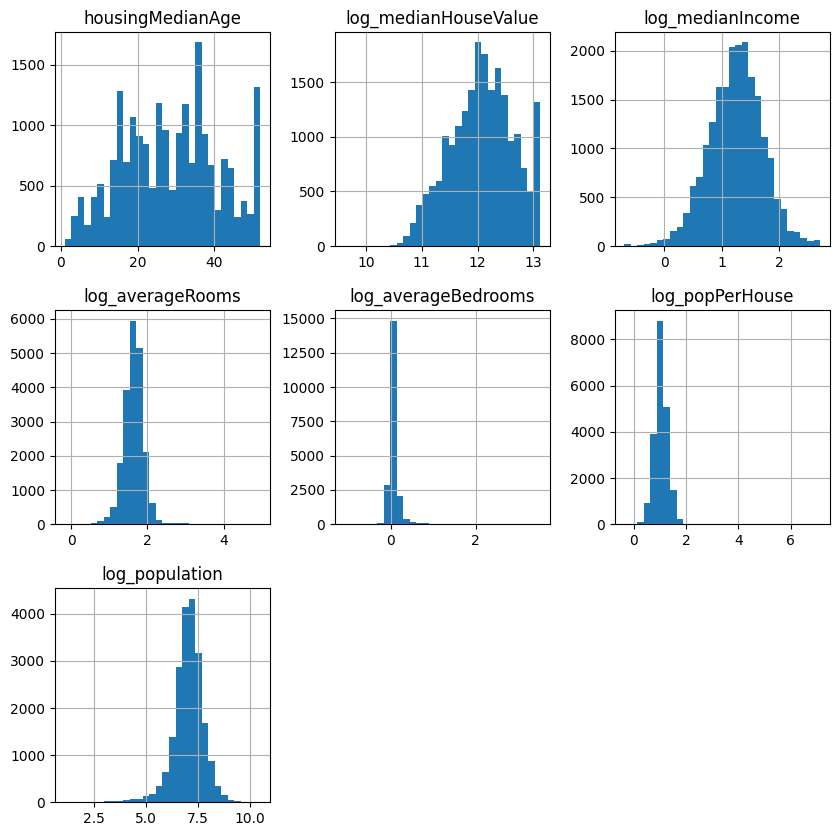

In [ ]:
# Histograms after feature engineering and log transformation
vars_df3.hist(bins=30, figsize=(10, 10))
plt.show()

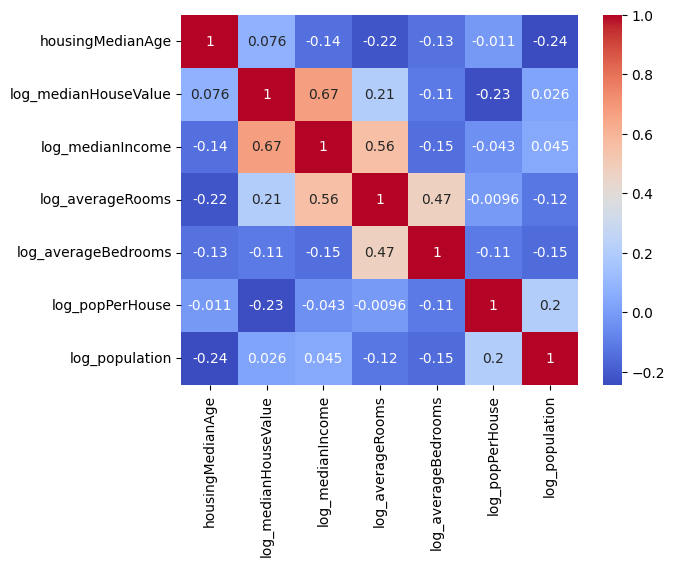

In [ ]:
# Correlation matrix after feature engineering and log transformation
corr_matrix = vars_df3.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# Create a GeoDataFrame
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(housing_df['longitude'], housing_df['latitude'])]
housing_gdf = gpd.GeoDataFrame(housing_df, geometry=geometry)
housing_gdf = housing_gdf.set_crs(epsg=4326)
housing_gdf = housing_gdf.to_crs(3857)

# getting xy coords
x = housing_gdf.geometry.centroid.x
y = housing_gdf.geometry.centroid.y
housing_df['x'] = x
housing_df['y'] = y
coords = np.column_stack((x,y))


[Text(0.5, 0, 'Latitude'), Text(0, 0.5, 'Longitude')]

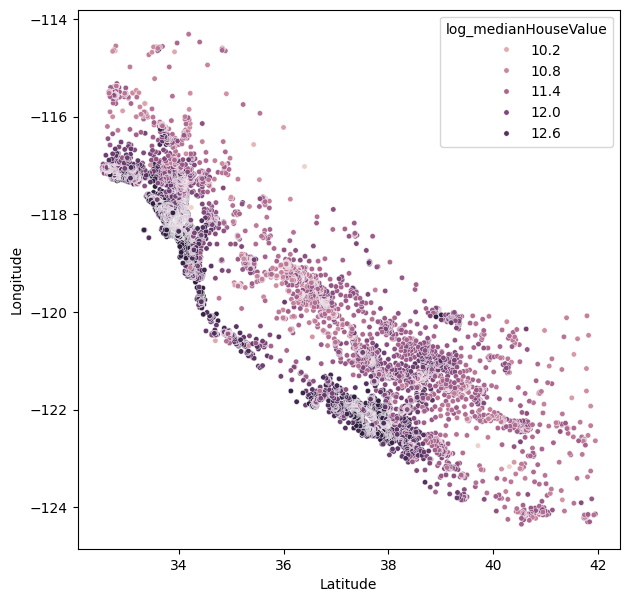

In [ ]:
# plotting spatial distribution of response variable
# Plotting outer kmeans splits
plt.figure(figsize=(7, 7))
sns.scatterplot(data=housing_df, x='latitude', y='longitude', hue = 'log_medianHouseValue', s = 15).set(xlabel='Latitude', ylabel='Longitude')

### Weights and lagged variables

In [ ]:
# creating weights matrices for the three distance bands #####################################################
# 5km weights
w_5000 = weights.distance.DistanceBand.from_dataframe(housing_gdf, 5000, binary=True, silence_warnings = True)
w_5000.transform = "R" # Row-standardization
# 20km weights
w_20000 = weights.distance.DistanceBand.from_dataframe(housing_gdf, 20000, binary=True, silence_warnings = True)
w_20000.transform = "R" # Row-standardization

### Creating lagged variables

In [ ]:
# Lagging variables and addeding to DF
variables = housing_df.drop(columns=['latitude', 'longitude', 'x', 'y']).columns
for i in range(len(variables)):
    var = variables[i]
    housing_df[f'{var}_lag5'] = weights.spatial_lag.lag_spatial(w_5000, housing_gdf[var])
    housing_df[f'{var}_lag20'] = weights.spatial_lag.lag_spatial(w_20000, housing_gdf[var])

In [ ]:
housing_df.columns

Index(['longitude', 'latitude', 'housingMedianAge', 'log_medianHouseValue',
       'log_medianIncome', 'log_averageRooms', 'log_averageBedrooms',
       'log_popPerHouse', 'log_population', 'x', 'y', 'housingMedianAge_lag5',
       'housingMedianAge_lag20', 'log_medianHouseValue_lag5',
       'log_medianHouseValue_lag20', 'log_medianIncome_lag5',
       'log_medianIncome_lag20', 'log_averageRooms_lag5',
       'log_averageRooms_lag20', 'log_averageBedrooms_lag5',
       'log_averageBedrooms_lag20', 'log_popPerHouse_lag5',
       'log_popPerHouse_lag20', 'log_population_lag5', 'log_population_lag20'],
      dtype='object')

In [ ]:
housing_df.to_csv('cali_housing_lag_vars.csv', index=False)